In [1]:
import sys
sys.path.append("../../smsl")

In [2]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import scipy.signal

from MDAnalysis.analysis import rms
from MDAnalysis.analysis import align

from smsl.config import ConfAgent
from smsl.trajTransfer import MDAgent
from smsl import mda
from smsl.plotAgent import PlotAgent, palette
from smsl.plotAgent import font_label, font_xylabel, font_xyticks

/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [3]:
class RMSAgent(dict, ConfAgent):
    def __init__(self):
        ConfAgent.__init__(self)
        self.end_ns = self.time_num
        self.framesperns = self.frame_num // self.time_num
    def load_systems(self, system2offical_name):
        ori_path = os.getcwd()
        for system, system_offical_name in system2offical_name.items():
            os.chdir(f'../../{system}/d.fluctmatch')
            md_agent = MDAgent()
            ## load_MDUniverse
            pdbFile = os.path.realpath(glob.glob('../c.gromacs.run_md/3.trajectory_data/*.npt2.pdb')[0])
            xtcFile = os.path.realpath(glob.glob('../c.gromacs.run_md/3.trajectory_data/*_5us5kf*.xtc')[0])
            print(f'Reading PDB file: {pdbFile}')
            print(f'Reading XTC file: {xtcFile}')
            md_agent.u_traj = mda.Universe(pdbFile, xtcFile)
            md_agent.ref_pdbFile = os.path.realpath(glob.glob(f'../c.gromacs.run_md/1.create_system/*.gro.pdb')[0])
            md_agent.u_ref = mda.Universe(md_agent.ref_pdbFile)
            md_agent.pdbid = md_agent.ref_pdbFile.split('/')[-1].split('.')[0]
            md_agent.system_offical_name = system_offical_name
            self[system] = md_agent
        os.chdir(ori_path)
    def get_df_rmsd(self):
        for system, md_agent in self.items():
            md_agent.df_rmsd = GetDfRmsd(md_agent.u_traj, md_agent.u_ref)
    def get_rmsf(self):
        for system, md_agent in self.items():
            md_agent.u_na, md_agent.rmsf = CalRMSF(md_agent.u_traj, select_tetrad_base, select_strand1)

In [4]:
def GetDfRmsd(u, u_ref):
    R = rms.RMSD(u, u_ref, select=select_tetrad_base, groupselections=[select_tetrad_bb, select_loop_bb, select_a1_bb])
    R.run(start=0, step=1, stop=-1, verbose=1)
    df_rmsd = pd.DataFrame(R.results.rmsd, columns=['Frame', 'Time(ps)', 'RMSD(Core Base)', 'RMSD(Core Backbone)', 'RMSD(Loop Backbone)', 'RMSD(A1 Backbone)'])
    df_rmsd['Time(ns)'] = df_rmsd['Time(ps)']/1000
    return df_rmsd

def CalRMSF(u, select_align, select_atoms):
    average = align.AverageStructure(u, select=select_align, ref_frame=0).run(verbose=1)
    ref = average.results.universe
    aligner = align.AlignTraj(u, ref, select=select_align, in_memory=True).run(verbose=1)
    u_na = u.select_atoms(select_atoms)
    R = rms.RMSF(u_na).run()
    return u_na, R.results.rmsf

def lowpass(data: np.ndarray, cutoff: float, sample_rate: float, poles: int = 5):
    sos = scipy.signal.butter(poles, cutoff, 'lowpass', fs=sample_rate, output='sos')
    filtered_data = scipy.signal.sosfiltfilt(sos, data)
    return filtered_data


In [5]:
gua_base           = "name N1 C2 N2 N3 C4 C5 C6 O6 N7 C8 N9"
select_na          = "nucleic"
select_strand1     = f"{select_na} and (id 1-715)"
select_na_bb       = f"{select_na} and name C3'"
select_strand1_bb  = f"{select_strand1} and name C3'"
select_tetrad_bb   = f"{select_strand1_bb} and resname DG"
select_a1_bb       = f"{select_strand1_bb} and resid 1"
select_loop_bb     = f"{select_strand1_bb} and not (resname DG or resid 1)"
select_tetrad_base = f"{select_strand1} and resname DG and ({gua_base})"

In [6]:
resn2color = {
'G' : "magenta",
'A' : "green",
'T' : "red",
}

In [7]:
resid2color = {
 1: palette[3],
 2: palette[1],
 3: palette[1],
 4: palette[1],
 5: palette[2],
 6: palette[2],
 7: palette[2],
 8: palette[1],
 9: palette[1],
10: palette[1],
11: palette[2],
12: palette[2],
13: palette[2],
14: palette[1],
15: palette[1],
16: palette[1],
17: palette[2],
18: palette[2],
19: palette[2],
20: palette[1],
21: palette[1],
22: palette[1],
}

In [8]:
system2offical_name = {
'propeller': 'Propeller',
'basket'   : 'Basket',
'chair'    : 'Chair',
'hybrid-i' : 'Hybrid-I',
'hybrid-ii': 'Hybrid-II',
}

rms_agent = RMSAgent()
rms_agent.load_systems(system2offical_name)

Reading PDB file: /home/user/workfolder/g4dna_protocol_demo/propeller/c.gromacs.run_md/3.trajectory_data/1kf1.npt2.pdb
Reading XTC file: /home/user/workfolder/g4dna_protocol_demo/propeller/c.gromacs.run_md/3.trajectory_data/1kf1_5us5kf.xtc
Reading PDB file: /home/user/workfolder/g4dna_protocol_demo/basket/c.gromacs.run_md/3.trajectory_data/143d.npt2.pdb
Reading XTC file: /home/user/workfolder/g4dna_protocol_demo/basket/c.gromacs.run_md/3.trajectory_data/143d_5us5kf.xtc
Reading PDB file: /home/user/workfolder/g4dna_protocol_demo/chair/c.gromacs.run_md/3.trajectory_data/6jkn.npt2.pdb
Reading XTC file: /home/user/workfolder/g4dna_protocol_demo/chair/c.gromacs.run_md/3.trajectory_data/6jkn_5us5kf.xtc
Reading PDB file: /home/user/workfolder/g4dna_protocol_demo/hybrid-i/c.gromacs.run_md/3.trajectory_data/2jsm.npt2.pdb
Reading XTC file: /home/user/workfolder/g4dna_protocol_demo/hybrid-i/c.gromacs.run_md/3.trajectory_data/2jsm_5us5kf.xtc
Reading PDB file: /home/user/workfolder/g4dna_protocol_d

### RMSD

In [9]:
rms_agent.get_df_rmsd()

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [10]:
!pwd

/home/user/workfolder/g4dna_protocol_demo/summary/d.fluctmatch


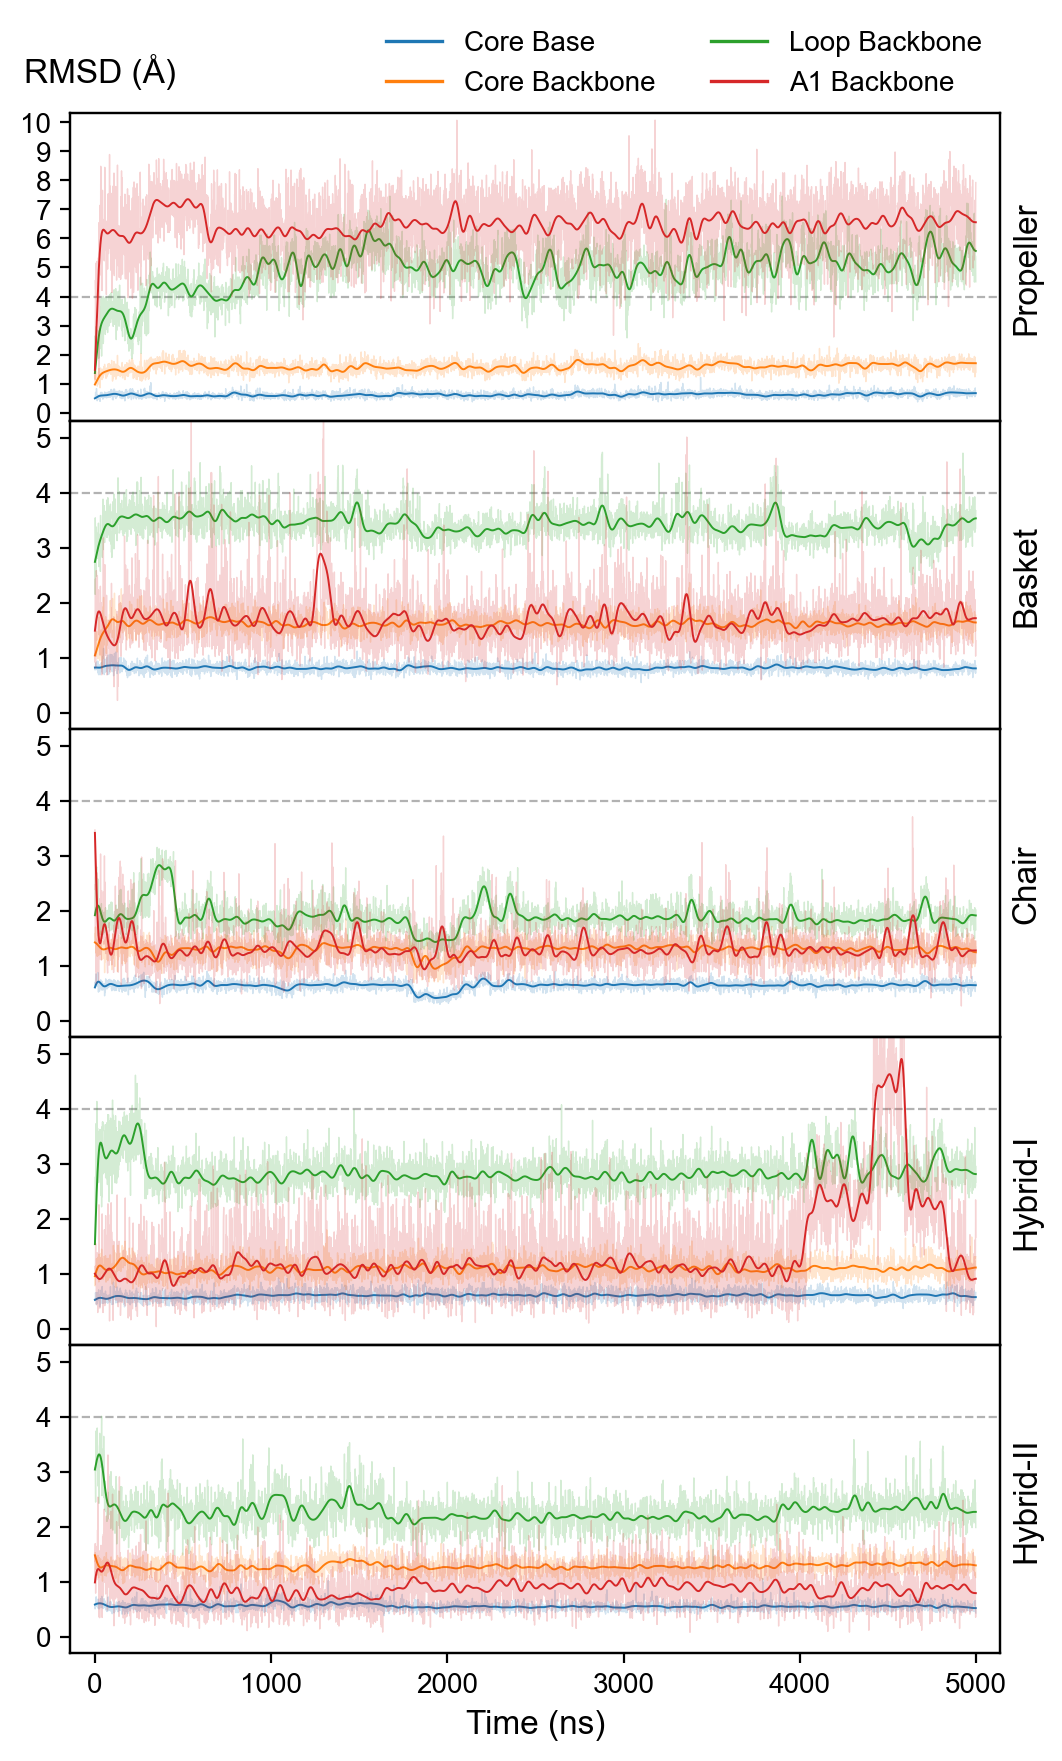

In [11]:
p_agent = PlotAgent(nrows=len(rms_agent), ncols=1, figsize_1=[6.0, 2.0], sharey=False)
for idx, (system, md_agent) in enumerate(rms_agent.items()):
    df_rmsd_filter = md_agent.df_rmsd.loc[:, md_agent.df_rmsd.columns.str.startswith('RMSD')]
    for i, (column, df_rmsd_one_column) in enumerate(df_rmsd_filter.items()):
        region = column.replace('RMSD(', '').replace(')', '')
        sample_rate = len(df_rmsd_one_column) / (md_agent.u_traj.trajectory.totaltime * 1e-12) ## 1e9 for 1 ns/sample
        p_agent.axs[idx].plot(md_agent.df_rmsd['Time(ns)'],  df_rmsd_one_column, alpha=0.2, color=palette[i], linewidth=0.5)
        p_agent.axs[idx].plot(md_agent.df_rmsd['Time(ns)'], lowpass(df_rmsd_one_column, 15e6, sample_rate), label=region, color=palette[i], linewidth=0.7)  
    if idx != 0:
        p_agent.axs[idx].set_ylim(-0.3, 5.3)
        p_agent.axs[idx].set_yticks(range(0, 5+1))
    else:
        p_agent.axs[idx].set_ylim(-0.3, 10.3)
        p_agent.axs[idx].set_yticks(range(0, 10+1))
    
p_agent.set_legend(ncols=2, bbox_to_anchor=(0.66, 1.35), linewidth=1.2)
p_agent.set_xticks(np.arange(0, 5001, 1000), x_padding=True, padding_scale=0.5)
p_agent.set_yticks()
p_agent.axhlines(ys=[4])
p_agent.set_xlabel_down('Time (ns)')
p_agent.set_ylabels(rms_agent, 'system_offical_name', position='right')
p_agent.set_supylabel('RMSD (Å)', x=0.15, y=0.91)
p_agent.savefig(f'RMSD_by_comformation.svg')

../../smsl/smsl/plotAgent.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels, fontdict=fontdict)


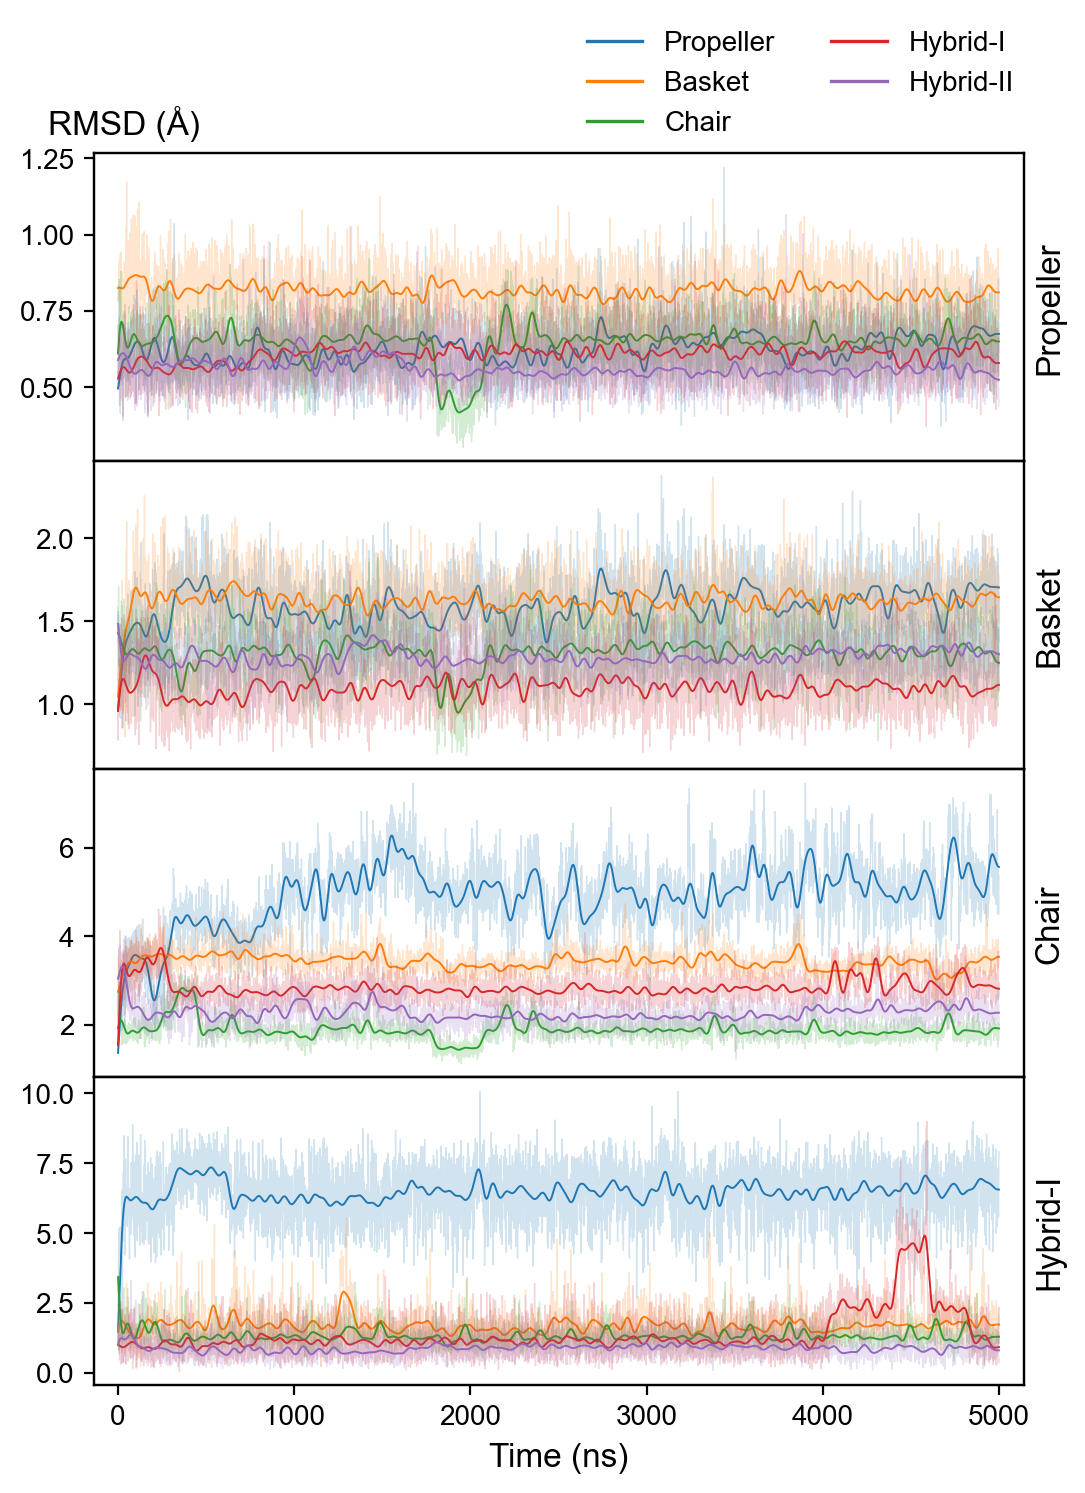

In [12]:
rmsd_count = sum(1 for df_rmsd_key in md_agent.df_rmsd.keys() if df_rmsd_key.startswith('RMSD'))
p_agent = PlotAgent(nrows=rmsd_count, ncols=1, figsize_1=[6.0, 2.0], sharey=False)

for idx, (system, md_agent) in enumerate(rms_agent.items()):
    df_rmsd_filter = md_agent.df_rmsd.loc[:, md_agent.df_rmsd.columns.str.startswith('RMSD')]
    for i, (column, df_rmsd_one_column) in enumerate(df_rmsd_filter.items()):
        region = column.replace('RMSD(', '').replace(')', '')
        sample_rate = len(df_rmsd_one_column) / (md_agent.u_traj.trajectory.totaltime * 1e-12) ## 1e9 for 1 ns/sample
        p_agent.axs[i].plot(md_agent.df_rmsd['Time(ns)'],  df_rmsd_one_column, alpha=0.2, color=palette[idx], linewidth=0.5)
        p_agent.axs[i].plot(md_agent.df_rmsd['Time(ns)'], lowpass(df_rmsd_one_column, 15e6, sample_rate), label=md_agent.system_offical_name, color=palette[idx], linewidth=0.7)  

p_agent.set_legend(ncols=2, bbox_to_anchor=(0.76, 1.48), linewidth=1.2)
p_agent.set_xticks(np.arange(0, 5001, 1000), x_padding=True, padding_scale=0.5)
p_agent.set_yticks()
p_agent.set_xlabel_down('Time (ns)')
p_agent.set_ylabels(rms_agent, 'system_offical_name', position='right')
p_agent.set_supylabel('RMSD (Å)', x=0.15, y=0.91)
p_agent.savefig(f'RMSD_by_region.svg')

In [13]:
## avg \pm std in 內文
region2system_offical_name2rmsd_statistic = {}
for system, md_agent in rms_agent.items():
    for column, rmsd in md_agent.df_rmsd.items():
        if 'RMSD' in column:
            region = column.split('RMSD(')[1].split(')')[0]
            if system=='hybrid-i' and region=='A1 Backbone':
                # return
                rmsd1 = rmsd[:4000]
                rmsd_statistic = f'{rmsd1.mean():.2f} $\pm$ {rmsd1.std():.2f}'
                rmsd2 = rmsd[4000:]
                rmsd_statistic += ' and ' + f'{rmsd2.mean():.2f} $\pm$ {rmsd2.std():.2f}'
            else:
                rmsd_statistic = f'{rmsd.mean():.2f} $\pm$ {rmsd.std():.2f}'
            region2system_offical_name2rmsd_statistic.setdefault(region, {})
            region2system_offical_name2rmsd_statistic[region][md_agent.system_offical_name] = rmsd_statistic

In [14]:
for region, system_offical_name2rmsd_statistic in region2system_offical_name2rmsd_statistic.items():
    print(region)
    for system_offical_name, rmsd_statistic in system_offical_name2rmsd_statistic.items():
        print(rmsd_statistic, end='、')
    print()

Core Base
0.62 $\pm$ 0.09、0.82 $\pm$ 0.07、0.65 $\pm$ 0.08、0.61 $\pm$ 0.08、0.56 $\pm$ 0.07、
Core Backbone
1.58 $\pm$ 0.19、1.62 $\pm$ 0.15、1.30 $\pm$ 0.15、1.10 $\pm$ 0.14、1.28 $\pm$ 0.12、
Loop Backbone
4.90 $\pm$ 0.83、3.43 $\pm$ 0.26、1.89 $\pm$ 0.26、2.85 $\pm$ 0.30、2.27 $\pm$ 0.29、
A1 Backbone
6.46 $\pm$ 0.98、1.69 $\pm$ 0.51、1.31 $\pm$ 0.34、1.10 $\pm$ 0.52 and 2.50 $\pm$ 1.26、0.87 $\pm$ 0.34、


### RMSF

In [11]:
rms_agent.get_rmsf()

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

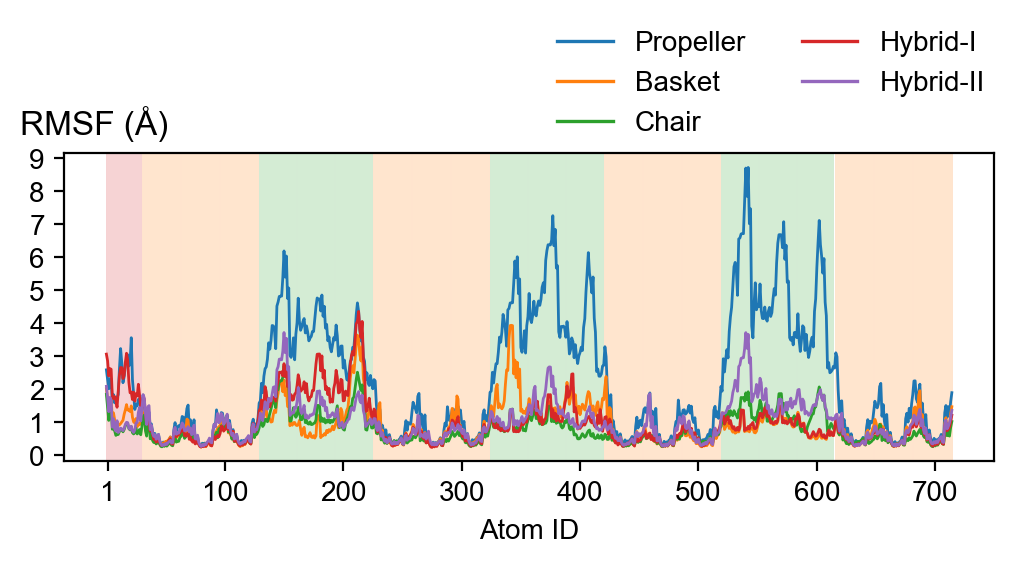

In [16]:
p_agent = PlotAgent(nrows=1, ncols=1, figsize_1=[6.0, 2.0], sharey=False)

for idx, (system, md_agent) in enumerate(rms_agent.items()):
    p_agent.axs.plot(md_agent.u_na.atoms.ix, md_agent.rmsf, label=md_agent.system_offical_name, linewidth=1.0)
    
for resid in range(1, md_agent.u_na.n_residues+1):
    u_sele = md_agent.u_na.select_atoms(f'resid {resid}')
    color = resid2color[resid]
    ix_max, ix_min = u_sele.ix.max(), u_sele.ix.min()
    p_agent.axs.axvspan(ix_min, ix_max, zorder=0, alpha=0.2, color=color, linewidth=0.2)

p_agent.set_legend(ncols=2, bbox_to_anchor=(0.76, 1.48), linewidth=1.2)
xticks = [1] + list(np.arange(100, 701, 100))
p_agent.axs.set_xticks(xticks)
p_agent.axs.set_xticklabels(xticks, fontdict=font_xyticks)
p_agent.axs.set_yticks(range(0, 9+1))
p_agent.axs.set_yticklabels(range(0,9+1), fontdict=font_xyticks)
p_agent.axs.set_xlabel('Atom ID', fontdict=font_xyticks)
p_agent.set_supylabel('RMSF (Å)', x=0.15, y=1.0)
# p_agent.savefig('RMSF_in_1.svg')

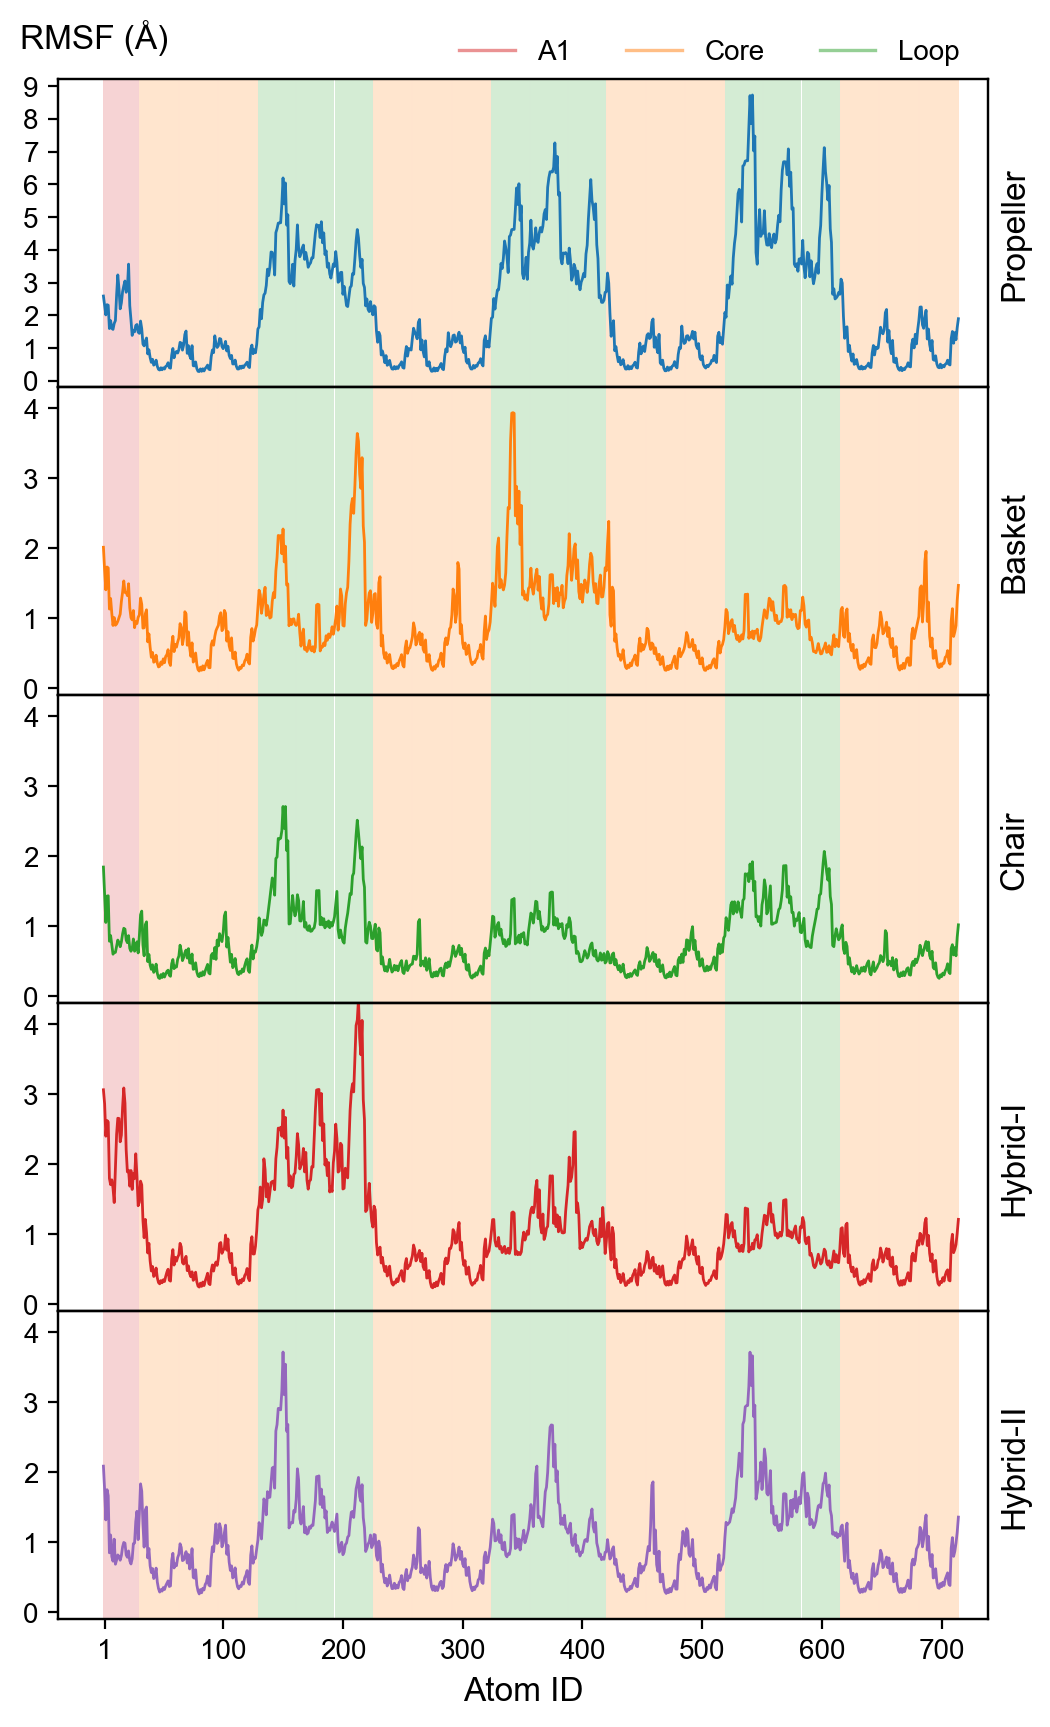

In [17]:
p_agent = PlotAgent(nrows=len(rms_agent), ncols=1, figsize_1=[6.0, 2.0], sharey=False)

for idx, (system, md_agent) in enumerate(rms_agent.items()):
    p_agent.axs[idx].plot(md_agent.u_na.atoms.ix, md_agent.rmsf, linewidth=1.0, color=palette[idx])
    if idx!=0:
        p_agent.axs[idx].set_ylim(-0.1, 4.3)
        p_agent.axs[idx].set_yticks(range(0, 4+1))
        p_agent.axs[idx].set_yticklabels(range(0, 4+1), fontdict=font_xyticks)
    else:
        p_agent.axs[idx].set_ylim(-0.2, 9.2)
        p_agent.axs[idx].set_yticks(range(0, 9+1))
        p_agent.axs[idx].set_yticklabels(range(0,9+1), fontdict=font_xyticks)
        
    for resid in range(1, md_agent.u_na.n_residues+1):
        u_sele = md_agent.u_na.select_atoms(f'resid {resid}')
        color = resid2color[resid]
        ix_max, ix_min = u_sele.ix.max(), u_sele.ix.min()
        p_agent.axs[idx].axvspan(ix_min, ix_max, zorder=0, alpha=0.2, color=color, linewidth=0.2)

xticks = [1] + list(np.arange(100, 701, 100))
p_agent.set_xticks(xticks, x_padding=True)
p_agent.set_xlabel_down('Atom ID')
p_agent.set_ylabels(rms_agent, 'system_offical_name', position='right')
p_agent.set_supylabel('RMSF (Å)', x=0.155, y=0.91)

p_agent.axs[0].plot([],[],label='A1'  , c=palette[3], alpha=0.5)
p_agent.axs[0].plot([],[],label='Core', c=palette[1], alpha=0.5)
p_agent.axs[0].plot([],[],label='Loop', c=palette[2], alpha=0.5)
p_agent.set_legend(ncols=3, bbox_to_anchor=(0.7, 1.21), linewidth=1.2)
# p_agent.savefig('RMSF_in_5.svg')

### B-Factor V.S. RMSF

In [18]:
def mapua2ub(ua, ub, verbose=False, is_sort=True):
    seq_shift = ub.select_atoms('resname DG').resids[0] - ua.select_atoms('resname DG').resids[0]
    A1_startwith = ua.select_atoms('resname DG').resids[0]-1
    if A1_startwith>1: ua = ua[(ua.resids>=A1_startwith) & (ua.resids<A1_startwith+22)][3:]
    ua2ub_ids = []
    for atom in ua.atoms:
        if verbose: print(atom)
        if atom.name == 'BR': atom.name = 'O6'
        sele_cmd = f'resid {atom.resid+seq_shift} and name {atom.name}'
        sele_atom = ub.select_atoms(sele_cmd).atoms[0]
        ua2ub_ids.append(sele_atom.id)
        if verbose: print(sele_atom, '\n')
    bfactors = ua.atoms.tempfactors
    if is_sort:
        bfactor_data = np.array([ua2ub_ids, bfactors])
        ua2ub_ids, bfactors = bfactor_data[:, np.argsort(bfactor_data[0])]
    return ua2ub_ids, bfactors

/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:328: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:432: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


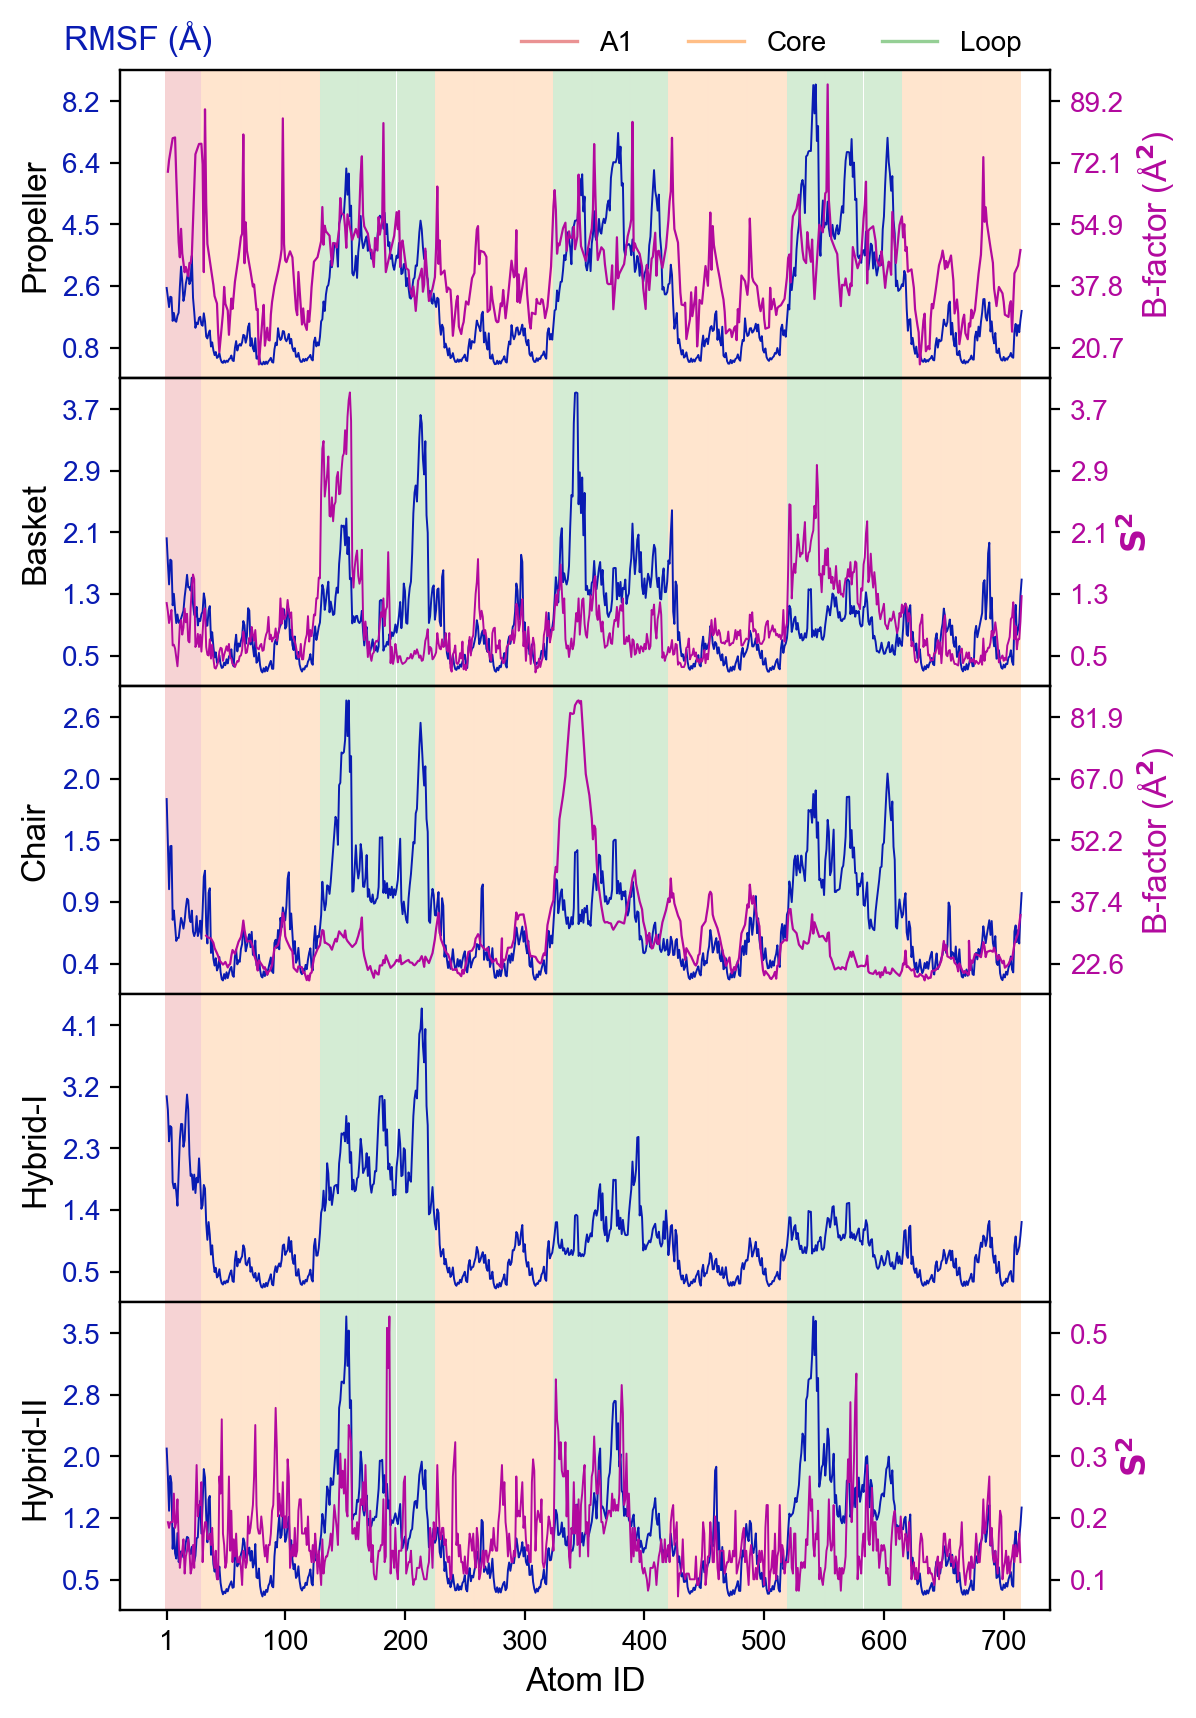

In [20]:
import numpy as np

rmsf_color = '#091bb2ff'
bfactor_color = '#b2099eff'


def set_custom_y_ticks(ax, percentage_ticks=[0.1, 0.3, 0.5, 0.7, 0.9]):
    # Get the current range of the y-axis
    y_min, y_max = ax.get_ylim()
    tick_values = [(y_max - y_min) * p + y_min for p in percentage_ticks]
    # Set the ticks and labels of the y-axis
    ax.set_yticks(tick_values)
    ax.set_yticklabels([f'{val:.1f}' for val in tick_values], fontdict=font_xyticks)

p_agent = PlotAgent(nrows=len(rms_agent), ncols=1, figsize_1=[6.0, 2.0], sharey=False)
for idx, (system, md_agent) in enumerate(rms_agent.items()):
    # RMSF Part
    ax1 = p_agent.axs[idx]
    ax1.plot(md_agent.u_na.ids, md_agent.rmsf, color=rmsf_color, linewidth=0.7)
    ax1.set_ylabel(f'RMSF of {md_agent.system_offical_name} (Å)', color=rmsf_color, fontdict=font_xylabel)
    ax1.tick_params(axis='y', labelcolor=rmsf_color)
    set_custom_y_ticks(ax1)

    # B-Factor Part
    u = mda.Universe(f'./structure/{md_agent.pdbid}.pdb') ## same as a.charmm.dna_setup/pdbid.pdb
    bfactor = u.atoms.tempfactors
    if 0 < max(bfactor) and max(bfactor) < 10: # NMR Order Parameter
        u = mda.Universe(f'./structure/{md_agent.pdbid}.mean_bfactor.pdb') ## same as 
    u_na = u.select_atoms('resname DA DT DC DG BGM')
    u = mda.Universe(f'./structure/{md_agent.pdbid}.pgro.pdb') ## same as c.gromacs.run_md/1.create_system/pdbid.pgro.pdb
    u_na_pgro = u.select_atoms('resname DA DT DC DG BGM')
    ua2ub_ids, bfactor = mapua2ub(u_na, u_na_pgro)
    
    if max(bfactor) == 0:  # no B-Factor
        pass
    elif max(bfactor) < 10:  # NMR Order Parameter
        ax2 = ax1.twinx()
        ax2.plot(ua2ub_ids, bfactor, color=bfactor_color, linewidth=0.7)
        ax2.set_ylabel(r'$\bf{S^2}$', color=bfactor_color, fontdict=font_xylabel)
        ax2.tick_params(axis='y', labelcolor=bfactor_color)
        set_custom_y_ticks(ax2)
    else:  # X-ray
        ax2 = ax1.twinx()
        ax2.plot(ua2ub_ids, bfactor, color=bfactor_color, linewidth=0.8)
        ax2.set_ylabel(r'B-factor (Å$\bf{^2}$)', color=bfactor_color, fontdict=font_xylabel)
        ax2.tick_params(axis='y', labelcolor=bfactor_color)
        set_custom_y_ticks(ax2)

    # add axvspan
    for resid in range(1, md_agent.u_na.n_residues+1):
        u_sele = md_agent.u_na.select_atoms(f'resid {resid}')
        color = resid2color[resid]
        ix_max, ix_min = u_sele.ix.max(), u_sele.ix.min()
        p_agent.axs[idx].axvspan(ix_min, ix_max, zorder=0, alpha=0.2, color=color, linewidth=0.2)

xticks = [1] + list(np.arange(100, 701, 100))
p_agent.set_xticks(xticks, x_padding=True)
p_agent.set_xlabel_down('Atom ID')
p_agent.set_ylabels(rms_agent, 'system_offical_name', c='black')
p_agent.set_supylabel('RMSF (Å)', x=0.14, y=0.905, c=rmsf_color)

p_agent.axs[0].plot([],[],label='A1'  , c=palette[3], alpha=0.5)
p_agent.axs[0].plot([],[],label='Core', c=palette[1], alpha=0.5)
p_agent.axs[0].plot([],[],label='Loop', c=palette[2], alpha=0.5)
p_agent.set_legend(ncols=3, bbox_to_anchor=(0.7, 1.21), linewidth=1.2)

p_agent.savefig('RMSF_vs_BFactor.svg')